In [26]:
import pandas as pd
import requests
import os
import numpy as np, pandas as pd
from datetime import datetime, timezone
from math import sqrt, exp, log
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Set the ticker symbol for fetching the spot price
TICKER = "JPM"
print(f"TICKER variable set to: {TICKER}")

# Load data from Parquet
try:
    ALL = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/VolSurf_ML/combined_options_data.parquet')
    print("Successfully loaded data from Parquet.")
    display(ALL.head())
except FileNotFoundError:
    print("Error: combined_options_data.parquet not found. Please make sure the file is in the correct location in your Google Drive.")
except Exception as e:
    print(f"An error occurred while loading the Parquet file: {e}")

TICKER variable set to: JPM
Successfully loaded data from Parquet.


,underlying_symbol,underlying_price,contract_symbol,expiry,dte,strike,type,open_interest,volume,last_trade_price,last_trade_time,bid,ask,change,change_percent,implied_volatility,in_the_money,currency,asof
0,JPM,304.4986,JPM251121P00115000,2025-11-21,6,115.0,put,330,1,0.03,2025-10-06 10:00:57-04:00,0.00,0.24,0.0,0.0,2.750003,False,USD,2025-11-15
1,JPM,304.4986,JPM251121P00120000,2025-11-21,6,120.0,put,26,1,0.04,2025-10-09 11:19:00-04:00,0.00,1.14,0.0,0.0,3.222658,False,USD,2025-11-15
2,JPM,304.4986,JPM251121P00125000,2025-11-21,6,125.0,put,64,1,0.03,2025-10-24 11:17:02-04:00,0.00,0.98,0.0,0.0,3.021487,False,USD,2025-11-15
3,JPM,304.4986,JPM251121C00130000,2025-11-21,6,130.0,call,0,2,180.50,2025-10-03 15:47:15-04:00,171.85,175.65,0.0,0.0,2.464848,True,USD,2025-11-15
4,JPM,304.4986,JPM251121P00130000,2025-11-21,6,130.0,put,15,2,0.05,2025-10-20 11:32:28-04:00,0.00,0.06,0.0,0.0,2.109380,False,USD,2025-11-15


In [27]:
def _d1(S,K,r,q,sigma,T):
    return (np.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*sqrt(T))
def _d2(d1,sigma,T): return d1 - sigma*sqrt(T)

def bs_price(is_call,S,K,r,q,sigma,T):
    if sigma <= 0 or T <= 0:
        return max(0.0, S*exp(-q*T) - K*exp(-r*T)) if is_call else max(0.0, K*exp(-r*T) - S*exp(-q*T))
    d1=_d1(S,K,r,q,sigma,T); d2=_d2(d1,sigma,T)
    if is_call:
        return S*exp(-q*T)*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2)
    else:
        return K*exp(-r*T)*norm.cdf(-d2) - S*exp(-q*T)*norm.cdf(-d1)

def implied_vol(is_call, S,K,r,q,T, price, lo=1e-6, hi=5.0):
    def f(sig): return bs_price(is_call,S,K,r,q,sig,T) - price
    try:
        flo, fhi = f(lo), f(hi)
        if flo*fhi > 0:
            for hi2 in (10.0, 20.0):
                fhi2 = f(hi2)
                if flo*fhi2 <= 0: hi = hi2; break
            else:
                return np.nan
        return brentq(f, lo, hi, maxiter=200, xtol=1e-8)
    except Exception:
        return np.nan

def _now_utc():
    return datetime.now(timezone.utc)

def _pick_source_df():
    g = globals()
    for name in ("ALL", "chain", "opt", "df"):
        if name in g:
            df = g[name]
            if isinstance(df, pd.DataFrame) and not df.empty:
                print(f"Using DataFrame variable: {name} (rows={len(df)})")
                return df.copy()
    raise RuntimeError("Could not find a non-empty DataFrame among ALL/chain/opt/df. Run your fetch cell first.")

def infer_forward_from_parity(df_exp, r):
    tmap = df_exp["type"].astype(str).str.lower().str[0]  # 'c' or 'p'
    df_exp = df_exp.assign(_t=tmap)
    calls = df_exp[df_exp["_t"]=="c"].set_index("strike")
    puts  = df_exp[df_exp["_t"]=="p"].set_index("strike")
    common = calls.index.intersection(puts.index)
    if len(common)==0: return np.nan
    Cmid = calls.loc[common,"mid"]
    Pmid = puts.loc[common,"mid"]
    K = common.to_numpy(dtype=float)
    T = float(df_exp["T"].iloc[0])
    DF_r = exp(-r*T)
    Fvals = K + (Cmid.values - Pmid.values)/DF_r
    Fvals = Fvals[np.isfinite(Fvals)]
    return np.median(Fvals) if len(Fvals) else np.nan

def recompute_clean_iv_surface(source_df: pd.DataFrame, r=0.045):
    df = source_df.copy()
    required = {"expiry","strike"}
    if not required.issubset(df.columns):
        missing = required - set(df.columns)
        raise ValueError(f"Missing columns in your data: {missing}. Ensure you fetched expiries & strikes.")

    df["expiry"] = pd.to_datetime(df["expiry"], errors="coerce")
    df = df.dropna(subset=["expiry","strike"])
    df["T"] = (df["expiry"].dt.normalize() - pd.Timestamp(_now_utc().date())).dt.days.clip(lower=0) / 365.0

    if "type" in df.columns:
        t = df["type"].astype(str).str.lower()
        df["type"] = np.where(t.str.startswith("c"), "call",
                       np.where(t.str.startswith("p"), "put", t))
    else:
        raise ValueError("Column 'type' not found; your fetch should include call/put labels.")

    for col in ("bid","ask","lastPrice"):
        if col not in df.columns: df[col] = np.nan
    df["mid"] = np.where(df[["bid","ask"]].notna().all(1), (df["bid"]+df["ask"])/2, df["lastPrice"])

    df = df[df["mid"]>0].copy()
    if {"bid","ask"}.issubset(df.columns):
        df["spread"] = df["ask"] - df["bid"]
        abs_cap = 0.25
        rel_cap = 0.80
        thr = np.where(df["mid"] < 1.0, abs_cap, rel_cap * df["mid"])
        df = df[(df["spread"] >= 0) & (df["spread"] <= thr)].copy()

    # Use 'lastPrice' as spot S if 'S' column is not present or is all NaN
    if "S" in df.columns and pd.notna(df["S"]).any():
        S = float(pd.to_numeric(df["S"], errors="coerce").dropna().iloc[0])
    elif "lastPrice" in df.columns and pd.notna(df["lastPrice"]).any():
        # Assuming 'lastPrice' at index 0 is representative of the current spot price
        S = float(pd.to_numeric(df["lastPrice"], errors="coerce").dropna().iloc[0])
    else:
        # Fallback to yfinance if no 'S' or 'lastPrice' is available or valid
        try:
            import yfinance as yf
            ticker_guess = globals().get("TICKER", None) # Use TICKER variable
            if not ticker_guess:
                raise RuntimeError("Set TICKER variable earlier to fetch S; or add an 'S' or 'lastPrice' column.")
            S = float(yf.Ticker(ticker_guess).history(period="1d")["Close"][-1])
        except Exception as e:
            raise RuntimeError("Cannot determine spot S. Provide an 'S' or 'lastPrice' column or ensure TICKER is set and yfinance works.") from e


    df["S"] = S
    df["k"] = np.log(df["strike"]/S)

    out = []
    for exp, g in df.groupby("expiry", sort=True):
        if g.empty: continue
        T = float(g["T"].iloc[0])
        if T <= 0: continue
        F = infer_forward_from_parity(g, r)
        if not np.isfinite(F): continue
        q = r - (1.0/T)*np.log(max(F,1e-12)/S)
        gg = g.copy()
        gg["iv_clean"] = gg.apply(lambda x: implied_vol(x["type"]=="call", S, x["strike"], r, q, T, x["mid"]), axis=1)
        gg = gg[(gg["iv_clean"]>0.0005) & (gg["iv_clean"]<10.0)]
        out.append(gg)

    clean = pd.concat(out, ignore_index=True) if out else pd.DataFrame()
    return clean

def build_surface(df, grid_k=60, grid_T=60):
    pts = df[["k","T"]].to_numpy()
    z   = df["iv_clean"].to_numpy()
    kmin,kmax = np.percentile(df["k"],2), np.percentile(df["k"],98)
    Tmin,Tmax = max(1e-6,float(df["T"].min())), float(df["T"].max())
    Klin = np.linspace(kmin,kmax,grid_k); Tlin = np.linspace(Tmin,Tmax,grid_T)
    KK, TT = np.meshgrid(Klin, Tlin)
    IV = griddata(pts, z, (KK,TT), method="linear")
    m = np.isnan(IV)
    if m.any():
        IV[m] = griddata(pts, z, (KK,TT), method="nearest")[m]
    return KK, TT, IV

def plot_surface(KK, TT, IV, title="IV Surface"):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(KK, TT, IV, linewidth=0, antialiased=True)
    ax.set_xlabel("log-moneyness  k = ln(K/S)")
    ax.set_ylabel("time to expiry T (years)")
    ax.set_zlabel("implied vol")
    ax.set_title(title)
    plt.show()

print("✅ IV helper cells added. Run the next cell to compute & plot.")

✅ IV helper cells added. Run the next cell to compute & plot.


In [28]:
# --- Robust IV surface builder & fallbacks ---

def plot_smile_1d(df, title="IV Smile (single expiry)"):
    g = df.sort_values("k")
    plt.figure(figsize=(8,4))
    plt.plot(g["k"], g["iv_clean"])
    plt.xlabel("log-moneyness  k = ln(K/S)")
    plt.ylabel("implied vol")
    plt.title(title + f"  |  T={g['T'].iloc[0]:.3f}y")
    plt.show()

def build_surface_robust(df, grid_k=60, grid_T=60, joggle=1e-8, prefer='linear'):
    """Return (KK, TT, IV) or (None, None, None) if only one expiry."""
    unique_T = np.unique(np.round(df["T"].values, 9))
    if len(unique_T) < 2:
        # Not enough maturities for a 2D surface
        return None, None, None

    pts = df[["k","T"]].to_numpy()
    z   = df["iv_clean"].to_numpy()

    # Check if T has tiny variance across points → joggle slightly
    if np.ptp(pts[:,1]) == 0:
        pts[:,1] = pts[:,1] + joggle*np.linspace(-1,1,len(pts))

    kmin, kmax = np.percentile(df["k"], 2), np.percentile(df["k"], 98)
    Tmin, Tmax = max(1e-6, float(df["T"].min())), float(df["T"].max())
    k_lin = np.linspace(kmin, kmax, grid_k)
    T_lin = np.linspace(Tmin, Tmax, grid_T)
    KK, TT = np.meshgrid(k_lin, T_lin)

    # Try preferred method then fallback to nearest
    try:
        IV = griddata(pts, z, (KK, TT), method=prefer)
        mask = np.isnan(IV)
        if np.any(mask):
            IV[mask] = griddata(pts, z, (KK, TT), method="nearest")[mask]
    except Exception:
        IV = griddata(pts, z, (KK, TT), method="nearest")
    return KK, TT, IV

def plot_surface(KK, TT, IV, title="IV Surface"):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(KK, TT, IV, linewidth=0, antialiased=True)
    ax.set_xlabel("log-moneyness  k = ln(K/S)")
    ax.set_ylabel("Time to expiry T (years)")
    ax.set_zlabel("implied vol")
    ax.set_title(title)
    plt.show()

def plot_heatmap(df, bins_k=40, title="IV heatmap (pivot)"):
    # Quick visualization that doesn't need triangulation
    k = df["k"].values
    T = df["T"].values
    iv = df["iv_clean"].values

    k_edges = np.linspace(np.percentile(k,2), np.percentile(k,98), bins_k+1)
    T_edges = np.unique(np.round(T, 6))  # 1 row per expiry
    # assign each row to k-bin and expiry
    k_idx = np.digitize(k, k_edges) - 1
    T_vals = np.round(T, 6)
    T_levels = np.unique(T_vals)
    T_map = {t:i for i,t in enumerate(T_levels)}
    T_idx = np.array([T_map[t] for t in T_vals])

    heat = np.full((len(T_levels), bins_k), np.nan)
    for i in range(len(iv)):
        if 0 <= k_idx[i] < bins_k:
            if np.isnan(heat[T_idx[i], k_idx[i]]):
                heat[T_idx[i], k_idx[i]] = iv[i]
            else:
                heat[T_idx[i], k_idx[i]] = 0.5*(heat[T_idx[i], k_idx[i]] + iv[i])

    plt.figure(figsize=(10,6))
    plt.imshow(heat, aspect="auto", origin="lower",
               extent=[k_edges[0], k_edges[-1], T_levels[0], T_levels[-1]])
    plt.colorbar(label="implied vol")
    plt.xlabel("log-moneyness  k")
    plt.ylabel("time to expiry T (years)")
    plt.title(title)
    plt.show()

Using DataFrame variable: ALL (rows=1592)


/tmp/ipython-input-3253436457.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S = float(yf.Ticker(ticker_guess).history(period="1d")["Close"][-1])


Points used: 1309 | Expiries: 20


,underlying_symbol,underlying_price,contract_symbol,expiry,dte,strike,type,open_interest,volume,last_trade_price,...,in_the_money,currency,asof,T,lastPrice,mid,spread,S,k,iv_clean
0,JPM,304.4986,JPM251121P00115000,2025-11-21,6,115.0,put,330,1,0.03,...,False,USD,2025-11-15,0.016438,NaN,0.120,0.24,303.609985,-0.970812,2.972822
1,JPM,304.4986,JPM251121P00130000,2025-11-21,6,130.0,put,15,2,0.05,...,False,USD,2025-11-15,0.016438,NaN,0.030,0.06,303.609985,-0.848209,2.276669
2,JPM,304.4986,JPM251121P00135000,2025-11-21,6,135.0,put,23,3,0.01,...,False,USD,2025-11-15,0.016438,NaN,0.040,0.08,303.609985,-0.810469,2.239674
3,JPM,304.4986,JPM251121P00140000,2025-11-21,6,140.0,put,39,1,0.06,...,False,USD,2025-11-15,0.016438,NaN,0.020,0.04,303.609985,-0.774102,2.014308
4,JPM,304.4986,JPM251121P00145000,2025-11-21,6,145.0,put,75,1,0.02,...,False,USD,2025-11-15,0.016438,NaN,0.040,0.08,303.609985,-0.739010,2.053253
5,JPM,304.4986,JPM251121C00150000,2025-11-21,6,150.0,call,0,1,165.67,...,True,USD,2025-11-15,0.016438,NaN,154.000,3.60,303.609985,-0.705109,2.099776
6,JPM,304.4986,JPM251121P00155000,2025-11-21,6,155.0,put,37,1,0.06,...,False,USD,2025-11-15,0.016438,NaN,0.025,0.05,303.609985,-0.672319,1.798558
7,JPM,304.4986,JPM251121C00160000,2025-11-21,6,160.0,call,2,3,142.60,...,True,USD,2025-11-15,0.016438,NaN,144.025,3.65,303.609985,-0.640570,1.964304
8,JPM,304.4986,JPM251121C00165000,2025-11-21,6,165.0,call,0,5,145.05,...,True,USD,2025-11-15,0.016438,NaN,139.025,3.65,303.609985,-0.609798,1.868767
9,JPM,304.4986,JPM251121P00165000,2025-11-21,6,165.0,put,67,1,0.30,...,False,USD,2025-11-15,0.016438,NaN,0.190,0.10,303.609985,-0.609798,2.038675


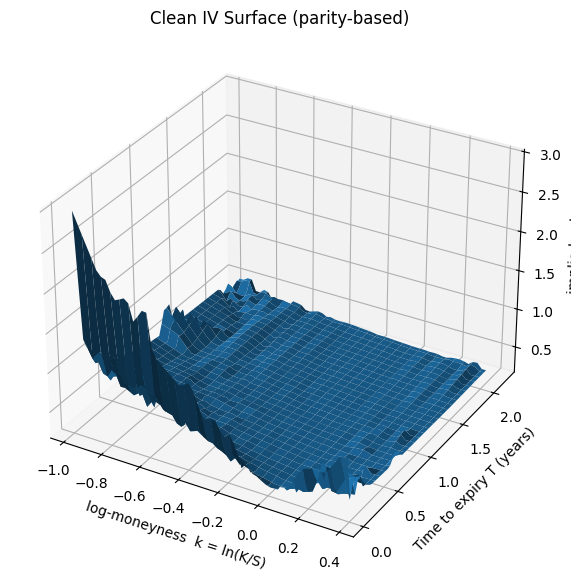

In [30]:
# --- Compute & plot IV surface
RATE_R = 0.045
SRC = _pick_source_df()
CLEAN = recompute_clean_iv_surface(SRC, r=RATE_R)

print(f"Points used: {len(CLEAN)} | Expiries: {CLEAN['expiry'].nunique()}")
display(CLEAN.head(10))

KK, TT, IV = build_surface_robust(CLEAN)
if KK is None:
  plot_smile_1d(CLEAN, title = "IV smile (single exp)")
else:
  plot_surface(KK, TT, IV, title = "Clean IV Surface (parity-based)")


In [31]:
print("\nDEBUG: Cleaned IV data summary")
print("Rows:", len(CLEAN))
print("Unique expiries:", CLEAN["expiry"].nunique())
print("Expiry list (up to 10):", CLEAN["expiry"].unique()[:10])
print("T range:", CLEAN["T"].min(), "-", CLEAN["T"].max())
print("IV range:", CLEAN["iv_clean"].min(), "-", CLEAN["iv_clean"].max())

# Count how many rows per expiry survived
print("\nRows per expiry after cleaning:")
print(CLEAN["expiry"].value_counts().sort_index())

# Check if T collapsed to one value (the Qhull flat case)
print("\nUnique T values:", np.unique(np.round(CLEAN['T'], 6)))


DEBUG: Cleaned IV data summary
Rows: 1309
Unique expiries: 20
Expiry list (up to 10): <DatetimeArray>
['2025-11-21 00:00:00', '2025-11-28 00:00:00', '2025-12-05 00:00:00',
 '2025-12-12 00:00:00', '2025-12-19 00:00:00', '2025-12-26 00:00:00',
 '2026-01-16 00:00:00', '2026-02-20 00:00:00', '2026-03-20 00:00:00',
 '2026-04-17 00:00:00']
Length: 10, dtype: datetime64[ns]
T range: 0.01643835616438356 - 2.1835616438356165
IV range: 0.2122608935945855 - 2.9728221841597544

Rows per expiry after cleaning:
expiry
2025-11-21     89
2025-11-28     37
2025-12-05     29
2025-12-12     22
2025-12-19     91
2025-12-26     14
2026-01-16    110
2026-02-20     69
2026-03-20     85
2026-04-17     70
2026-05-15     50
2026-06-18     98
2026-07-17     31
2026-08-21     60
2026-09-18     68
2026-12-18     71
2027-01-15     78
2027-06-17     80
2027-12-17     86
2028-01-21     71
Name: count, dtype: int64

Unique T values: [0.016438 0.035616 0.054795 0.073973 0.093151 0.112329 0.169863 0.265753
 0.342466 0.

In [32]:
# Save the CLEAN DataFrame to a Parquet file
CLEAN.to_parquet('/content/drive/MyDrive/Colab Notebooks/VolSurf_ML/cleaned_options_data.parquet', index=False)
print("Cleaned data saved to 'cleaned_options_data.parquet' in your Google Drive.")

Cleaned data saved to 'cleaned_options_data.parquet' in your Google Drive.


In [33]:
# Save the KK, TT, and IV grids to .npy files
np.save('/content/drive/MyDrive/Colab Notebooks/VolSurf_ML/KK_grid.npy', KK)
np.save('/content/drive/MyDrive/Colab Notebooks/VolSurf_ML/TT_grid.npy', TT)
np.save('/content/drive/MyDrive/Colab Notebooks/VolSurf_ML/IV_grid.npy', IV)

print("Surface grids (KK, TT, IV) saved to .npy files in your Google Drive.")

Surface grids (KK, TT, IV) saved to .npy files in your Google Drive.
